In [31]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch, json
import random
import numpy as np
import tqdm
from utils_batch import InfillingModel
from torch.nn.functional import log_softmax
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc



device = "cuda:1" # for GPU usage or "cpu" for CPU usage

In [32]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce GTX 1050 Ti with Max-Q Design
Memory Usage:
Allocated: 0.7 GB
Cached:    4.4 GB


In [33]:
def plot_roc_curve(human_scores, gpt_scores):
    # Data
    A, B = human_scores, gpt_scores
    # Combine scores and true labels
    scores = A + B
    labels = [0] * len(A) + [1] * len(B)
    # check amount of NaNs in scores
    if np.isnan(human_scores).any():
        print("Warning: NaNs in scores")
        print(np.argwhere(np.isnan(scores)))
    if np.isnan(gpt_scores).any():
        print("Warning: NaNs in scores")
        print(np.argwhere(np.isnan(scores)))
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(labels, scores)
    # Calculate AUC (Area Under Curve)
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve: Open-gen w/ GPT3.5-Reddit w prompts' )
    plt.legend(loc="lower right")
    plt.show()
    # what is the TPR for FPR = 0.1?
    for idx, fpr_ in enumerate(fpr):
        if fpr_ > 0.1:
            print(f"TPR at 1% FPR: {tpr[idx]:.4f}")
            break
    return roc_auc, tpr[idx]

In [34]:
model_name = "NinedayWang/PolyCoder-160M"
# NinedayWang/PolyCoder-0.4B
# NinedayWang/PolyCoder-2.7B
# model_name = 'codeparrot/codeparrot'
PyCodeGPT = AutoModelForCausalLM.from_pretrained( model_name ).to(device)
PyCodeGPT_tokenizer = AutoTokenizer.from_pretrained( model_name )

In [35]:
# from transformers import LlamaForCausalLM, LlamaTokenizer
# model_name = "/data/xianjun/project/llama/7B_hf/"
# model = LlamaForCausalLM.from_pretrained( model_name ).half().to(device) #.half() to use FP16
# model.eval() 
# PyCodeGPT = model
# PyCodeGPT_tokenizer = LlamaTokenizer.from_pretrained( model_name ) #.half() to use FP16

In [36]:
from transformers import AutoConfig
# Load the model's configuration
config = AutoConfig.from_pretrained(model_name)
# Get the default max_length
max_length = config.max_position_embeddings
max_length

2048

In [37]:
# give an input, return the logits of input tokens
inputs = 'this is a test'
truncate_ratio=0.9
def get_logprob1(inputs):
    input_ids = PyCodeGPT_tokenizer.encode(inputs, return_tensors='pt').to(device)
    input_ids = input_ids[:, :max_length]
    with torch.no_grad():
        output = PyCodeGPT(input_ids)
    logits = output[0]
    # Assuming the `logits` tensor contains the output from the model
    log_probs = log_softmax(logits, dim=-1)
    # Select the log probabilities for the specific tokens in the input
    input_log_probs = log_probs[0, torch.arange(log_probs.size(1)), input_ids[0]]
    # Multiply by -1 to get the negative log probabilities
    neg_log_probs = -input_log_probs
    neg_log_probs = neg_log_probs.cpu().numpy().tolist()
    return np.average( neg_log_probs[int( truncate_ratio*len(neg_log_probs)): ] ), neg_log_probs

In [38]:
#### merge the datasets
with open('FIM/codebert_competition_test_FIM_human_1_line_8.jsonl', 'r') as f:
    data1  = [json.loads(line) for line in f]
len(data1)

9

In [39]:
# sample couple of lines and json dump them
machine_text = data1[2]
print(json.dumps(machine_text, indent=4))

{
    "code": "n = int(input())\na = list(map(int, input().split()))\nb = list(map(int, input().split()))\n\na.sort()\nb.sort()\n\noperations = 0\ni = 0\nfor card in a:\n    if card != b[i]:\n        operations += abs(b[i] - card) + 1\n        i += 1\n\nprint(operations)",
    "label": 1,
    "label_name": "machine_generated",
    "difficulty": "competition",
    "original_source": "results\\gemma-7b-it-apps_competition_207.jsonl",
    "problem_id": "3819",
    "question": "Provide me the Python3 codes for solving the question: Nauuo is a girl who loves playing cards.\n\nOne day she was playing cards but found that the cards were mixed with some empty ones.\n\nThere are $n$ cards numbered from $1$ to $n$, and they were mixed with another $n$ empty cards. She piled up the $2n$ cards and drew $n$ of them. The $n$ cards in Nauuo's hands are given. The remaining $n$ cards in the pile are also given in the order from top to bottom.\n\nIn one operation she can choose a card in her hands and 

In [40]:
human_sample = data1[6]
human_text = human_sample['code']
print(json.dumps(human_sample, indent=4))

{
    "code": "import math\n\nw, h, a = list(map(int, input().strip().split()))\n\nif h >   w:\n    w, h = h, w\n\nif a > 90:\n    a = 90 - (a - 90)\n\na = math.radians(a)\n\nif a < 2 * math.atan2(h, w):\n    area = w * h\n\n    s = (w / 2) - (h / 2 * math.tan(a / 2))\n    bigger_area = 0.5 * s * s * math.tan(a)\n\n    s = (h / 2) - (w / 2 * math.tan(a / 2))\n    lower_area = 0.5 * s * s * math.tan(a)\n\n    print(area - 2 * bigger_area - 2 * lower_area)\nelse:\n    print(h * h / math.sin(a))\n\n",
    "label": 0,
    "label_name": "human_written",
    "difficulty": "competition",
    "original_source": "results\\gemma-7b-it-apps_competition_207.jsonl",
    "problem_id": "3869",
    "question": "Provide me the Python3 codes for solving the question: You are given two rectangles on a plane. The centers of both rectangles are located in the origin of coordinates (meaning the center of the rectangle's symmetry). The first rectangle's sides are parallel to the coordinate axes: the length o

In [41]:
len(data1[0]['FIM_code'])

4

In [42]:
avg_neg_log_probs, neg_log_probs = get_logprob1(human_text)
neg_log_probs[-500:]

[9.845521926879883,
 11.268424034118652,
 1.8296817541122437,
 2.0289697647094727,
 12.589674949645996,
 10.971261978149414,
 13.684554100036621,
 10.650894165039062,
 13.412403106689453,
 11.911151885986328,
 16.779949188232422,
 17.044918060302734,
 10.836897850036621,
 12.507379531860352,
 11.571760177612305,
 14.76645278930664,
 13.716184616088867,
 14.425106048583984,
 16.193763732910156,
 19.78028678894043,
 12.882283210754395,
 19.30945587158203,
 1.5542083978652954,
 2.7913856506347656,
 15.31559944152832,
 15.529424667358398,
 13.241166114807129,
 4.335653781890869,
 1.131523609161377,
 14.248655319213867,
 11.496476173400879,
 4.962856769561768,
 0.07226791977882385,
 0.044418081641197205,
 3.018101692199707,
 14.451943397521973,
 15.506417274475098,
 14.81694221496582,
 12.50899600982666,
 18.35797882080078,
 12.84453010559082,
 19.52277183532715,
 0.5182459354400635,
 3.1185078620910645,
 17.698137283325195,
 14.952346801757812,
 12.91288948059082,
 15.3098783493042,
 14.70

In [43]:
# give an input, return the logits of input tokens
truncate_ratio=0.9
def get_logprob(inputs):
    input_ids = PyCodeGPT_tokenizer.encode(inputs, return_tensors='pt').to(device)
    input_ids = input_ids[:, :max_length]
    with torch.no_grad():
        output = PyCodeGPT(input_ids)
    logits = output[0]
    # Assuming the `logits` tensor contains the output from the model
    log_probs = log_softmax(logits, dim=-1)
    # Select the log probabilities for the specific tokens in the input
    input_log_probs = log_probs[0, torch.arange(log_probs.size(1)), input_ids[0]]
    # Multiply by -1 to get the negative log probabilities
    neg_log_probs = -input_log_probs
    neg_log_probs = neg_log_probs.cpu().numpy().tolist()
    return np.average( neg_log_probs[int( truncate_ratio*len(neg_log_probs)): ] )

In [44]:
prob_all = []
for id, ins in tqdm.tqdm(enumerate(data1), total=len(data1)):
    temp = []
    if len( ins['FIM_code']) > 1:
        original_score = get_logprob(ins['code'])
        miu_scores = []
        for i in range( len(ins['FIM_code'] ) ):
            one_regen = ins['FIM_code'][i]['text']
            miu_scores.append(get_logprob( one_regen ))
        miu_scores_average_score = np.average( miu_scores )
        dx = original_score - miu_scores_average_score
        prob_all.append(dx)

100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


In [45]:

    # gold_prob_all = []
    # for id, ins in tqdm.tqdm(enumerate(data1), total=len(data1)):
    #     temp = []
    #     if len( ins['human_gen_text']['choices'] ) > 1:
    #         original_score = get_logprob( ins['gold_completion'] ) - get_logprob( ins['human_prefix_prompt'] )
    #         miu_scores = []
    #         for i in range( len(ins['human_gen_text']['choices'] ) ):
    #             one_regen = ins['human_prefix_prompt'] + ins['human_gen_text']['choices'][i]['message']['content']
    #             miu_scores.append( get_logprob( one_regen ) - get_logprob( ins['human_prefix_prompt'] ) )
    #         miu_scores_average_score = np.average( miu_scores )
    #         dx = original_score - miu_scores_average_score
    #         gold_prob_all.append( dx )
   

  0%|          | 0/9 [00:00<?, ?it/s]


KeyError: 'human_gen_text'

In [46]:
prob_all

[-5.772621554151049,
 -2.009807519698768,
 0.2515669494008623,
 0.6986040705726282,
 0.5004341636385252,
 1.4464485702060514,
 -3.5405941268695695,
 -0.8307613319273308,
 3.6047856620697427]

In [47]:
human_scores = []
machine_scores = []
for ind, ins in tqdm.tqdm(enumerate(data1), total=len(data1)):
    if ins['label'] == 0:
        human_scores.append(prob_all[ind])
    else:
        machine_scores.append(prob_all[ind])
        

100%|██████████| 9/9 [00:00<?, ?it/s]


In [48]:
print(len(human_scores))
print(human_scores)

3
[-3.5405941268695695, -0.8307613319273308, 3.6047856620697427]


In [49]:
print(len(machine_scores))
print(machine_scores)

6
[-5.772621554151049, -2.009807519698768, 0.2515669494008623, 0.6986040705726282, 0.5004341636385252, 1.4464485702060514]


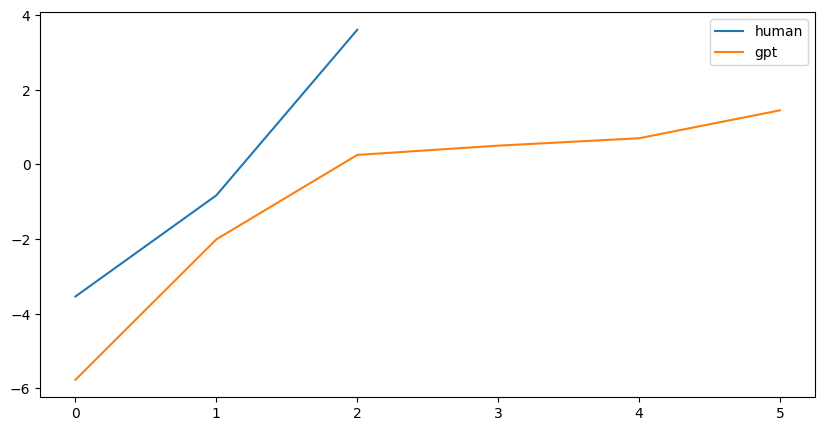

In [50]:
# plot and give different colors
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(sorted(human_scores), label='human')
plt.plot(sorted(machine_scores), label='gpt')
plt.legend()
plt.show()

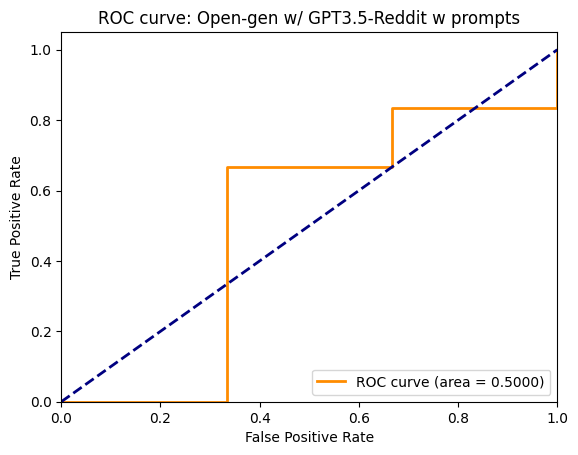

TPR at 1% FPR: 0.0000


(0.5, 0.0)

In [51]:


plot_roc_curve(human_scores, machine_scores)

In [52]:
# count negative values
print( len( [i for i in human_scores if i < 0] ) )
print( len( [i for i in machine_scores if i < 0] ) )

2
2


In [53]:
print(gold_prob_all)

[]
